In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import resize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize

import os

In [1]:
!pip3 install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 3.8MB 33.2MB/s 
     |████████████████████████████████| 450kB 56.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

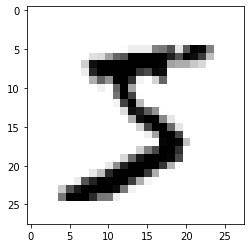

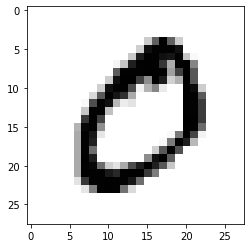

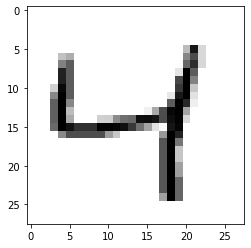

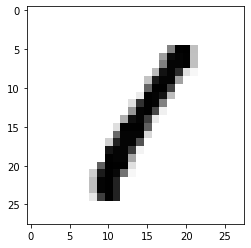

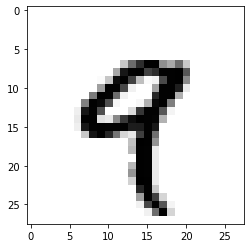

In [0]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
X_train = np.stack([X_train]*3, axis=-1)
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
X_test = np.stack([X_test]*3, axis=-1)
y_test = y_test.astype(int)

In [0]:
def init_block(x, filters):
    x = L.Conv2D(filters=filters, kernel_size=1, 
                 input_shape=input_shape, padding="SAME")(x)
    return x

In [0]:
def f(x, filters):
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    
    return x

def rev_block(x, filters):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=3)
    y1 = f(x2, filters // 2) + x1
    y2 = f(y1, filters // 2) + x2

    return tf.concat([y1, y2], axis=3)

# Модель с Reversible блоком, но в конце которой находятся Dense слои:

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 10

In [0]:
def build_model():
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    x = L.Dense(100)(x)
    x = L.Activation("relu")(x)
    x = L.Dense(n_classes)(x)
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)

    return model

In [0]:
model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 32)   128         input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_4 (TensorFlow [(None, 28, 28, 16), 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 28, 28, 16)   64          tf_op_layer_split_4[0][1]        
____________________________________________________________________________________________

In [0]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52416/52500 [============================>.] - ETA: 0s - loss: 2.3425 - sparse_categorical_accuracy: 0.6589
Epoch 00001: val_loss improved from inf to 0.88950, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 13s 243us/sample - loss: 2.3401 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.7757
Epoch 2/40
52224/52500 [============================>.] - ETA: 0s - loss: 0.6189 - sparse_categorical_accuracy: 0.8334
Epoch 00002: val_loss improved from 0.88950 to 0.40819, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 12s 224us/sample - loss: 0.6184 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.2397 - sparse_categorical_accuracy: 0.9389
Epoch 00003: val_loss improved from 0.40819 to 0.16

**Переобучение сети на маленьком батче:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

earlystopper = keras.callbacks.EarlyStopping(monitor="loss", patience=5, 
                                             verbose=1)

model.fit(X_train[:32], y_train[:32],
          batch_size=32, epochs=40,
          callbacks=[earlystopper])

Train on 32 samples
Epoch 1/40
32/32 [==============================] - 1s 32ms/sample - loss: 52.8831 - sparse_categorical_accuracy: 0.1562
Epoch 2/40
32/32 [==============================] - 0s 441us/sample - loss: 158.0528 - sparse_categorical_accuracy: 0.4688
Epoch 3/40
32/32 [==============================] - 0s 430us/sample - loss: 188.1282 - sparse_categorical_accuracy: 0.5000
Epoch 4/40
32/32 [==============================] - 0s 432us/sample - loss: 128.7907 - sparse_categorical_accuracy: 0.5312
Epoch 5/40
32/32 [==============================] - 0s 352us/sample - loss: 66.2178 - sparse_categorical_accuracy: 0.6562
Epoch 6/40
32/32 [==============================] - 0s 346us/sample - loss: 22.7801 - sparse_categorical_accuracy: 0.7188
Epoch 7/40
32/32 [==============================] - 0s 340us/sample - loss: 5.4840 - sparse_categorical_accuracy: 0.8438
Epoch 8/40
32/32 [==============================] - 0s 383us/sample - loss: 2.0206 - sparse_categorical_accuracy: 0.9375
Epoc

**LR range test** (https://www.kaggle.com/paultimothymooney/learning-rate-finder-for-keras):

In [0]:
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if math.isnan(loss) or loss > self.best_loss * 1000:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        self.model.save_weights('tmp.h5')

        original_lr = K.get_value(self.model.optimizer.lr)

        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        self.model.load_weights('tmp.h5')

        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, y_lim=(0, 100)):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.figure(figsize=(12, 8))
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        x = self.lrs[n_skip_beginning:-n_skip_end]
        y = self.losses[n_skip_beginning:-n_skip_end]
        plt.plot(x, y)
        plt.xscale('log')
        plt.ylim(y_lim)

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)


Для SGD:

Train on 52500 samples
16384/52500 [========>.....................] - ETA: 4s - loss: 252.6918 - sparse_categorical_accuracy: 0.4140

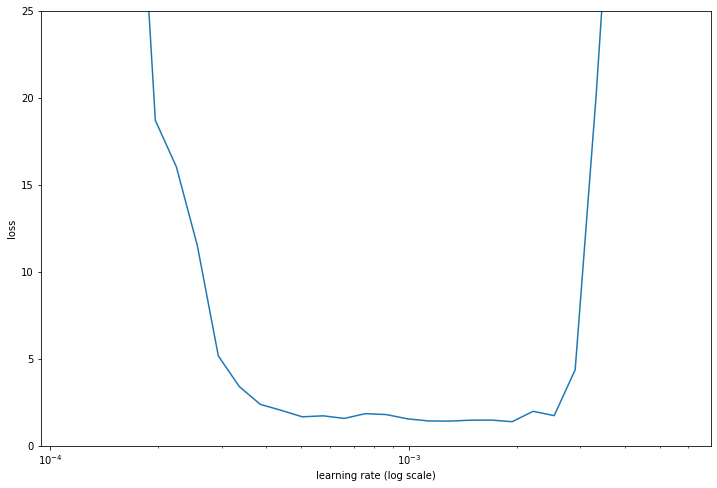

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

Посмотрим качество обучения для лучших lr:

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52192/52500 [============================>.] - ETA: 0s - loss: 1.1177 - sparse_categorical_accuracy: 0.7969
Epoch 00001: val_loss improved from inf to 0.57685, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 218us/sample - loss: 1.1140 - sparse_categorical_accuracy: 0.7974 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.8753
Epoch 2/40
52448/52500 [============================>.] - ETA: 0s - loss: 0.4586 - sparse_categorical_accuracy: 0.8939
Epoch 00002: val_loss improved from 0.57685 to 0.45376, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 202us/sample - loss: 0.4585 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.9013
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.3565 - sparse_categorical_accuracy: 0.9154
Epoch 00003: val_loss improved from 0.45376

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.0988
Epoch 00001: val_loss did not improve from inf
52500/52500 [==============================] - 12s 231us/sample - loss: nan - sparse_categorical_accuracy: 0.0988 - val_loss: nan - val_sparse_categorical_accuracy: 0.0979
Epoch 2/40
16192/52500 [========>.....................] - ETA: 6s - loss: nan - sparse_categorical_accuracy: 0.0980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

В последнем случае SGD функция потерь сразу ушла в nan

Посмотрим то же самое для Adam:

Train on 52500 samples
34816/52500 [==================>...........] - ETA: 1s - loss: 16.5278 - sparse_categorical_accuracy: 0.5558

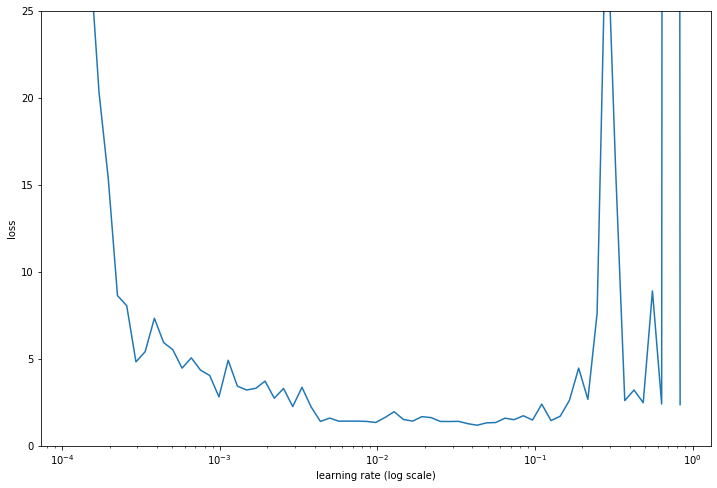

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: 9.8800 - sparse_categorical_accuracy: 0.4767
Epoch 00001: val_loss improved from inf to 1.23393, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 238us/sample - loss: 9.8766 - sparse_categorical_accuracy: 0.4767 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.6214
Epoch 2/40
52288/52500 [============================>.] - ETA: 0s - loss: 1.7716 - sparse_categorical_accuracy: 0.3961
Epoch 00002: val_loss did not improve from 1.23393
52500/52500 [==============================] - 11s 218us/sample - loss: 1.7735 - sparse_categorical_accuracy: 0.3956 - val_loss: 2.0485 - val_sparse_categorical_accuracy: 0.2289
Epoch 3/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.2555 - sparse_categorical_accuracy: 0.1552
Epoch 00003: val_loss did not improve from 1.23393
52500/52500 [============================

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.7939 - sparse_categorical_accuracy: 0.4979
Epoch 00001: val_loss improved from inf to 1.18438, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 13s 251us/sample - loss: 2.7865 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.6418
Epoch 2/40
52416/52500 [============================>.] - ETA: 0s - loss: 0.9230 - sparse_categorical_accuracy: 0.7089
Epoch 00002: val_loss improved from 1.18438 to 0.65049, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 222us/sample - loss: 0.9231 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.7808
Epoch 3/40
52256/52500 [============================>.] - ETA: 0s - loss: 0.4861 - sparse_categorical_accuracy: 0.8548
Epoch 00003: val_loss improved from 0.65049 t

Лучше себя показало значение по умолчанию равное 0.001

**Среднее, дисперсия и максимальное значение выходов каждого слоя** (https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer):

In [0]:
def count_output_stats(model, data):
    inp = model.input                                         
    outputs = [layer.output for layer in model.layers]
    functors = [K.function([inp], [out]) for out in outputs]   

    layer_outs = np.array([func(data)[0] for func in functors])

    print("Layer_name     Mean      Std     AbsMax")
    for out, layer in zip(layer_outs, model.layers):
        print(layer.name, np.mean(out), np.std(out), np.max(np.abs(out)))

In [0]:
model = keras.models.load_model('revnet_with_dense.hdf5')
count_output_stats(model, X_train[:32])

Layer_name     Mean      Std     AbsMax
input_26 33.669403 78.76575 255.0
conv2d_125 0.34469685 3.6137059 25.740976
tf_op_layer_split_25 0.34469682 3.6137064 25.740976
batch_normalization_100 -0.040776733 1.0181673 3.634192
activation_147 0.3284836 0.7104299 3.634192
conv2d_126 -0.20385407 3.2157915 20.416842
batch_normalization_101 -0.18014385 1.0640172 5.8735495
activation_148 0.23189177 0.664201 5.593438
conv2d_127 -0.06973644 2.491622 19.98863
tf_op_layer_add_50 0.32768622 2.2203338 17.570183
batch_normalization_102 -0.147246 0.9671924 8.543778
activation_149 0.22942124 0.66501045 8.543778
conv2d_128 0.060606577 2.08692 17.628712
batch_normalization_103 -0.20750129 1.1196847 8.575382
activation_150 0.22977695 0.7793017 8.126232
conv2d_129 -0.10059774 3.0193844 30.934013
tf_op_layer_add_51 0.19137326 2.74274 25.824512
tf_op_layer_concat_25 0.2595297 2.496176 25.824512
flatten_25 0.2595297 2.496176 25.824512
dense_44 -149.66223 137.3638 826.3128
activation_151 3.0253463 26.151455 470

**Grad norms** (https://stackoverflow.com/questions/57759635/get-gradients-with-keras-tensorflow-2-0):

In [0]:
class GradientCallback(tf.keras.callbacks.Callback):

    def on_batch_end(self, batch, logs=None):
        loss = self.model.total_loss
        optimizer = self.model.optimizer
        gradients = optimizer.get_gradients(loss, self.model.trainable_weights)
        for t in gradients:
            print('Tensor: {}'.format(t.name))
            print('{}\n'.format(t.numpy()[:10]))

Данный код кидает ошибку:

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

gradient_callback = GradientCallback()

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test),
          callbacks=[gradient_callback])

Train on 52500 samples, validate on 17500 samples
Tensor: Adam/gradients_39/gradients/conv2d_161/Conv2D_grad/Conv2DBackpropFilter:0
    0/52500 [..............................] - ETA: 0s

AttributeError: ignored

**Свой training loop** (https://www.tensorflow.org/guide/keras/train_and_evaluate):

In [0]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [0]:
model = build_model()

optimizer = keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

epochs = 3
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      logits = model(x_batch_train, training=True)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, logits)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log every 200 batches.
    if step % 200 == 0:
        print(logits)
        print(y_batch_train)
        print(train_acc_metric(y_batch_train, logits))
        print([tf.norm(grad).numpy() for grad in grads])
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0002707e-06 6.7088198e-36 4.2565485e-15
  0.0000000e+00 9.9999905e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.9756083e-26 1.5139476e-26 0.0000000e+00 3.6670054e-19
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0

KeyboardInterrupt: ignored

Непонятно почему вырождается в константную модель, хотя вроде с теми же оптимизаторами и функциями потерь обычный fit работает нормально:

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
52500/52500 [==============================] - 13s 255us/sample - loss: 2.5533 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.8377


# Атака на tinyImageNet:

In [6]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip &> log

--2020-02-22 09:29:00--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.8MB/s    in 14s     

2020-02-22 09:29:15 (16.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
num_classes = 20
wnids_file = os.path.join("tiny-imagenet-200", 'wnids.txt')
with open(wnids_file, 'r') as f:
    wnids = [x.strip() for x in f]

wnids = wnids[:num_classes]
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

In [0]:

X_train = []
y_train = []
for i, wnid in enumerate(wnids):
    boxes_file = os.path.join("tiny-imagenet-200", 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
        filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 64, 64, 3), dtype=np.int64)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
        img_file = os.path.join("tiny-imagenet-200", 'train', wnid, 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_train_block[j] = img

    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [0]:
indeces = np.arange(len(X_train))
np.random.shuffle(indeces)
X_train = np.resize(X_train[indeces], (len(indeces), 64, 64, 3)) / 255.
y_train = np.resize(y_train[indeces], (len(indeces),))

Class : 0


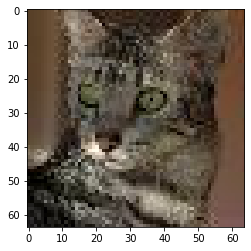


Class : 4


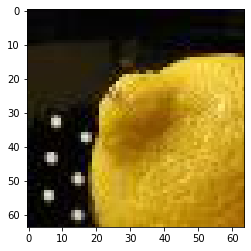


Class : 8


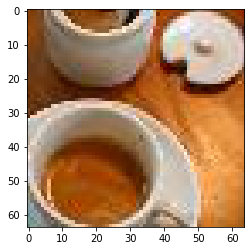


Class : 12


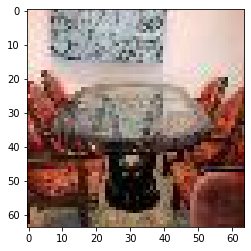


Class : 10


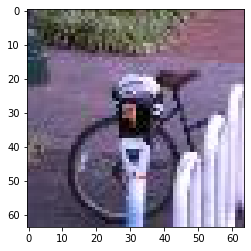

In [10]:
for i in range(5):
    print("Class :", y_train[i])
    plt.imshow(X_train[i])
    plt.show()
    print()

In [0]:
with open(os.path.join("tiny-imagenet-200", 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
        if line.split()[1] in wnids:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    X_val = np.zeros((num_val, 64, 64, 3), dtype=np.int64)
 
    for i, img_file in enumerate(img_files):
        img_file = os.path.join("tiny-imagenet-200", 'val', 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_val[i] = img

In [0]:
indeces = np.arange(len(X_val))
np.random.shuffle(indeces)
X_val = np.resize(X_val[indeces], (len(indeces), 64, 64, 3)) / 255.
y_val = np.resize(y_val[indeces], (len(indeces),))

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 20

In [0]:
def build_model(dropout=0):
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    x = L.Dense(100)(x)
    x = L.Activation("relu")(x)

    if dropout:
        x = L.Dropout(dropout)(x)

    x = L.Dense(n_classes)(x)
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)

    return model

In [17]:
model = build_model(dropout=0.3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   128         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 64, 64, 16), 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          tf_op_layer_split[0][1]          
______________________________________________________________________________________________

In [0]:
model = build_model()

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9984/10000 [============================>.] - ETA: 0s - loss: 3.7537 - sparse_categorical_accuracy: 0.1167
Epoch 00001: val_loss improved from inf to 2.97838, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 549us/sample - loss: 3.7520 - sparse_categorical_accuracy: 0.1169 - val_loss: 2.9784 - val_sparse_categorical_accuracy: 0.1210
Epoch 2/40
 9952/10000 [============================>.] - ETA: 0s - loss: 2.4001 - sparse_categorical_accuracy: 0.2805
Epoch 00002: val_loss improved from 2.97838 to 2.41224, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 450us/sample - loss: 2.3981 - sparse_categorical_accuracy: 0.2810 - val_loss: 2.4122 - val_sparse_categorical_accuracy: 0.2700
Epoch 3/40
 9888/10000 [============================>.] - ETA: 0s - loss: 1.8793 - sparse_categorical_accuracy: 0.4349
Epoch 00003: val_loss did not improv

In [0]:
model = build_model(dropout=0.3)

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9920/10000 [============================>.] - ETA: 0s - loss: 2.7339 - sparse_categorical_accuracy: 0.1964
Epoch 00001: val_loss improved from inf to 2.95664, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 524us/sample - loss: 2.7311 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.9566 - val_sparse_categorical_accuracy: 0.1290
Epoch 2/40
 9888/10000 [============================>.] - ETA: 0s - loss: 2.0761 - sparse_categorical_accuracy: 0.3731
Epoch 00002: val_loss improved from 2.95664 to 2.39497, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 4s 446us/sample - loss: 2.0752 - sparse_categorical_accuracy: 0.3733 - val_loss: 2.3950 - val_sparse_categorical_accuracy: 0.3110
Epoch 3/40
 9952/10000 [============================>.] - ETA: 0s - loss: 1.3745 - sparse_categorical_accuracy: 0.5822
Epoch 00003: val_loss did not improv

In [0]:
model = build_model(dropout=0.5)

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9952/10000 [============================>.] - ETA: 0s - loss: 2.9146 - sparse_categorical_accuracy: 0.1248
Epoch 00001: val_loss improved from inf to 2.99395, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 6s 563us/sample - loss: 2.9133 - sparse_categorical_accuracy: 0.1252 - val_loss: 2.9940 - val_sparse_categorical_accuracy: 0.0770
Epoch 2/40
 9888/10000 [============================>.] - ETA: 0s - loss: 2.5648 - sparse_categorical_accuracy: 0.2374
Epoch 00002: val_loss improved from 2.99395 to 2.43179, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 4s 445us/sample - loss: 2.5648 - sparse_categorical_accuracy: 0.2373 - val_loss: 2.4318 - val_sparse_categorical_accuracy: 0.3120
Epoch 3/40
 9984/10000 [============================>.] - ETA: 0s - loss: 2.1834 - sparse_categorical_accuracy: 0.3416
Epoch 00003: val_loss improved from 

**Добавим аугментацию:**

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [21]:
model = build_model()

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Диплом/revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train for 313 steps, validate on 1000 samples
Epoch 1/40
310/313 [============================>.] - ETA: 0s - loss: 3.0293 - sparse_categorical_accuracy: 0.1643
Epoch 00001: val_loss improved from inf to 2.94643, saving model to drive/My Drive/Диплом/revnet_with_dense_imagenet.hdf5
313/313 [==============================] - 16s 50ms/step - loss: 3.0247 - sparse_categorical_accuracy: 0.1648 - val_loss: 2.9464 - val_sparse_categorical_accuracy: 0.1140
Epoch 2/40
311/313 [============================>.] - ETA: 0s - loss: 2.4744 - sparse_categorical_accuracy: 0.2622
Epoch 00002: val_loss did not improve from 2.94643
313/313 [==============================] - 15s 46ms/step - loss: 2.4730 - sparse_categorical_accuracy: 0.2631 - val_loss: 2.9683 - val_sparse_categorical_accuracy: 0.2090
Epoch 3/40
310/313 [============================>.] - ETA: 0s - loss: 2.2869 - sparse_categorical_accuracy: 0.3144
Epoch 00003: val_loss improved from 2.94643 to 2.58511, saving model to drive/My Drive/Диплом/

In [22]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train for 313 steps, validate on 1000 samples
Epoch 1/40
312/313 [============================>.] - ETA: 0s - loss: 1.4212 - sparse_categorical_accuracy: 0.5563
Epoch 00001: val_loss improved from 1.70415 to 1.70139, saving model to drive/My Drive/Диплом/revnet_with_dense_imagenet.hdf5
313/313 [==============================] - 16s 50ms/step - loss: 1.4208 - sparse_categorical_accuracy: 0.5565 - val_loss: 1.7014 - val_sparse_categorical_accuracy: 0.5040
Epoch 2/40
312/313 [============================>.] - ETA: 0s - loss: 1.3966 - sparse_categorical_accuracy: 0.5680
Epoch 00002: val_loss did not improve from 1.70139
313/313 [==============================] - 15s 48ms/step - loss: 1.3957 - sparse_categorical_accuracy: 0.5684 - val_loss: 1.7771 - val_sparse_categorical_accuracy: 0.5010
Epoch 3/40
312/313 [============================>.] - ETA: 0s - loss: 1.3766 - sparse_categorical_accuracy: 0.5684
Epoch 00003: val_loss did not improve from 1.70139
313/313 [==============================

In [23]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=30, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer])

Train for 313 steps, validate on 1000 samples
Epoch 1/30
310/313 [============================>.] - ETA: 0s - loss: 1.2948 - sparse_categorical_accuracy: 0.5915
Epoch 00001: val_loss did not improve from 1.69028
313/313 [==============================] - 15s 47ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.8823 - val_sparse_categorical_accuracy: 0.4740
Epoch 2/30
310/313 [============================>.] - ETA: 0s - loss: 1.2799 - sparse_categorical_accuracy: 0.6026
Epoch 00002: val_loss did not improve from 1.69028
313/313 [==============================] - 15s 48ms/step - loss: 1.2804 - sparse_categorical_accuracy: 0.6025 - val_loss: 2.3686 - val_sparse_categorical_accuracy: 0.4230
Epoch 3/30
309/313 [============================>.] - ETA: 0s - loss: 1.2700 - sparse_categorical_accuracy: 0.6019
Epoch 00003: val_loss improved from 1.69028 to 1.68747, saving model to drive/My Drive/Диплом/revnet_with_dense_imagenet.hdf5
313/313 [==============================

In [0]:
model = build_model()
model.load_weights("drive/My Drive/Диплом/revnet_with_dense_imagenet.hdf5")

**Атака:**

In [0]:
from gradient_attack import choose_images, attack

Attacked image: 
Logits:  [0.00077907 0.19931142 0.23017682 0.01417201 0.00447104 0.00326355
 0.06159423 0.01164146 0.00404123 0.0502559  0.15582368 0.03745408
 0.01408335 0.00638505 0.00101968 0.10263831 0.00115606 0.00189566
 0.09464204 0.00519537]
Predicted:  2
Real:  2


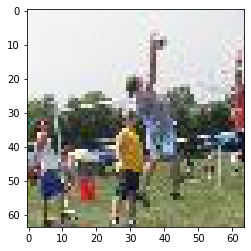

Changing image: 
Logits:  [8.61244189e-05 5.16761793e-03 3.37138947e-04 1.87002532e-02
 7.32718917e-08 3.56339541e-07 1.89500744e-04 1.29715445e-05
 6.16573612e-04 3.00394278e-03 1.44203138e-02 3.09232018e-05
 9.31729019e-01 8.44268811e-07 1.20610662e-06 4.65772930e-04
 1.80172685e-06 6.90060278e-06 8.64171074e-04 2.43645161e-02]
Predicted:  12
Real:  12


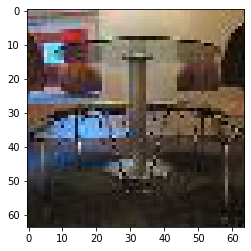

In [68]:
attacked_img, changed_img = choose_images(model, X_val=X_val, y_val=y_val)

Loss :  0.014666803
Predict of changing image:  12
Logits of changing image:  [8.55408725e-04 6.24151975e-02 5.45066455e-03 1.01780124e-01
 2.00497402e-06 1.66974660e-05 7.52349477e-03 1.76599657e-04
 3.68355541e-03 3.94479930e-02 1.63381040e-01 7.82502466e-04
 4.22250867e-01 4.28417879e-05 2.89926593e-05 2.17402959e-03
 3.39253093e-05 9.22983600e-05 1.51104126e-02 1.74751341e-01]
Logits of attacked image:  [0.00077907 0.19931142 0.23017682 0.01417201 0.00447104 0.00326355
 0.06159423 0.01164146 0.00404123 0.0502559  0.15582368 0.03745408
 0.01408335 0.00638505 0.00101968 0.10263831 0.00115606 0.00189566
 0.09464204 0.00519537]
Changed image:


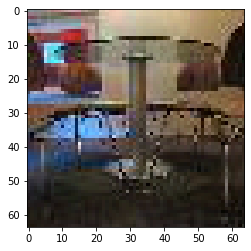

Source image to be changed:


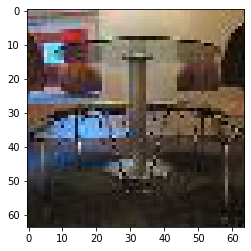

Loss :  0.0063084895
Predict of changing image:  2
Logits of changing image:  [0.00468489 0.04594979 0.5025802  0.00854406 0.00112316 0.00143162
 0.15883216 0.0006943  0.01233028 0.05707563 0.03417503 0.01874873
 0.00626543 0.00174965 0.00075119 0.07223819 0.00176721 0.00055101
 0.04751805 0.0229893 ]
Logits of attacked image:  [0.00077907 0.19931142 0.23017682 0.01417201 0.00447104 0.00326355
 0.06159423 0.01164146 0.00404123 0.0502559  0.15582368 0.03745408
 0.01408335 0.00638505 0.00101968 0.10263831 0.00115606 0.00189566
 0.09464204 0.00519537]
Changed image:


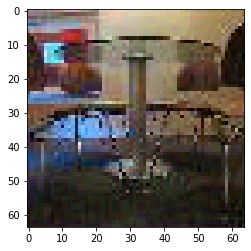

Source image to be changed:


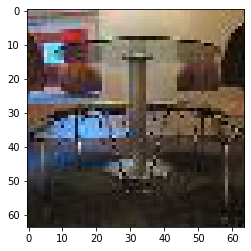

Loss :  0.003357216
Predict of changing image:  10
Logits of changing image:  [0.00438307 0.19761999 0.08129524 0.02200935 0.00098301 0.00142332
 0.02431438 0.00068265 0.0212296  0.08776801 0.35327917 0.0202569
 0.01067814 0.00331967 0.00265786 0.05646622 0.00090579 0.00185909
 0.08934741 0.01952125]
Logits of attacked image:  [0.00077907 0.19931142 0.23017682 0.01417201 0.00447104 0.00326355
 0.06159423 0.01164146 0.00404123 0.0502559  0.15582368 0.03745408
 0.01408335 0.00638505 0.00101968 0.10263831 0.00115606 0.00189566
 0.09464204 0.00519537]
Changed image:


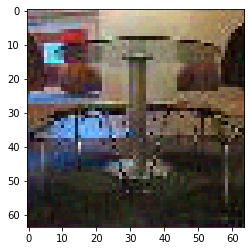

Source image to be changed:


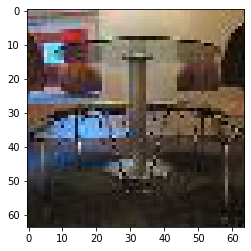

Loss :  0.0022892118
Predict of changing image:  1
Logits of changing image:  [0.00602446 0.3404367  0.12526356 0.02293312 0.00145396 0.00138566
 0.07277833 0.00051055 0.03654686 0.116501   0.13555516 0.01826733
 0.01389939 0.00395562 0.0012579  0.0166551  0.00106534 0.000756
 0.06764429 0.01710967]
Logits of attacked image:  [0.00077907 0.19931142 0.23017682 0.01417201 0.00447104 0.00326355
 0.06159423 0.01164146 0.00404123 0.0502559  0.15582368 0.03745408
 0.01408335 0.00638505 0.00101968 0.10263831 0.00115606 0.00189566
 0.09464204 0.00519537]
Changed image:


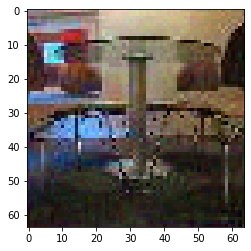

Source image to be changed:


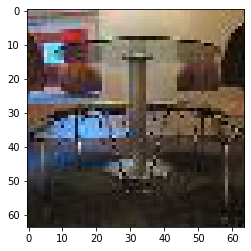

In [69]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign)

Attacked image: 
Logits:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Predicted:  8
Real:  8


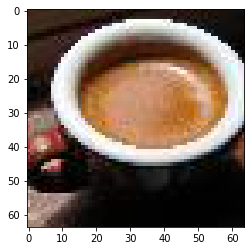

Changing image: 
Logits:  [7.0450830e-07 1.7307969e-04 2.4472713e-06 3.3844873e-07 1.2829688e-08
 3.8652261e-06 1.4534282e-06 9.9918884e-01 5.5502852e-07 1.0709633e-06
 9.7036333e-05 1.0333439e-05 2.6064892e-09 9.0711751e-08 3.4950275e-04
 4.0945662e-05 4.5623523e-08 1.4159580e-05 1.1550735e-04 4.9159937e-08]
Predicted:  7
Real:  7


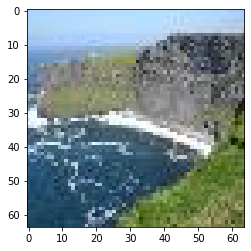

In [70]:
attacked_img, changed_img = choose_images(model, X_val=X_val, y_val=y_val)

Loss :  0.09027546
Predict of changing image:  7
Logits of changing image:  [4.35248912e-05 3.15440372e-02 5.79883694e-04 8.60231085e-05
 1.28456795e-05 3.63406638e-04 4.89207159e-04 8.95934045e-01
 9.25181739e-05 3.19964252e-04 1.61430910e-02 3.49345122e-04
 8.85971417e-07 2.69604243e-05 4.18026671e-02 2.46921694e-03
 1.90071278e-05 4.36279952e-04 9.27043613e-03 1.67363251e-05]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


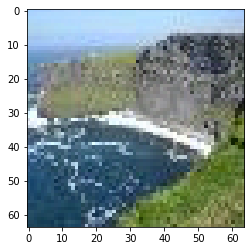

Source image to be changed:


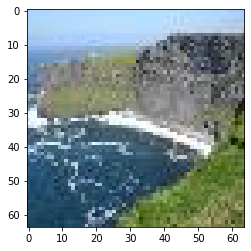

Loss :  0.04891647
Predict of changing image:  14
Logits of changing image:  [0.01722031 0.10570375 0.02192873 0.02022968 0.02664535 0.03058393
 0.03603004 0.09315424 0.06582034 0.03771671 0.08935192 0.01397178
 0.00340312 0.01073511 0.23124142 0.03934937 0.00266455 0.02007763
 0.12869783 0.00547423]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


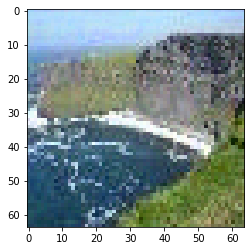

Source image to be changed:


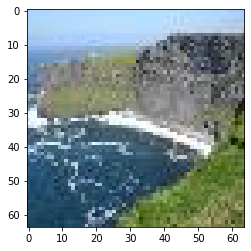

Loss :  1.6393352e-09
Predict of changing image:  8
Logits of changing image:  [3.4079856e-06 1.9300927e-05 5.3811995e-08 4.7697904e-07 6.2863123e-06
 3.6884089e-08 6.1867945e-07 1.0608723e-05 9.9977940e-01 1.8940927e-06
 2.8765509e-05 3.7400869e-09 1.7416491e-05 2.0378441e-10 1.5623602e-05
 3.1126860e-06 6.4330097e-09 7.9944213e-05 1.7422406e-05 1.5750133e-05]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


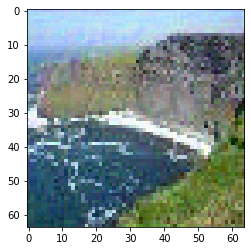

Source image to be changed:


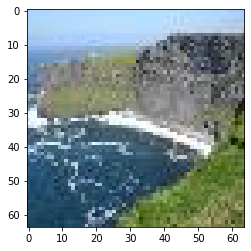

Loss :  2.7752898e-09
Predict of changing image:  8
Logits of changing image:  [3.6256477e-06 1.1660830e-05 2.0996328e-08 2.4401285e-07 4.3033260e-06
 4.3650321e-08 2.4138120e-07 1.1248739e-05 9.9974507e-01 8.5824553e-07
 1.7537881e-05 2.4740983e-09 1.1873062e-05 1.2762308e-10 1.3718526e-05
 2.3261684e-06 6.8394312e-09 1.5231472e-04 1.3518868e-05 1.1554074e-05]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


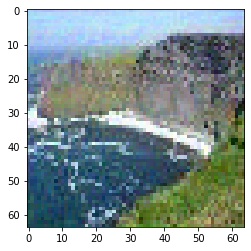

Source image to be changed:


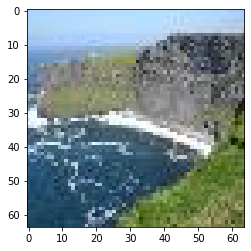

In [71]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign)

Loss :  0.099699125
Predict of changing image:  7
Logits of changing image:  [2.4160861e-06 5.4648193e-04 1.0979895e-05 1.6745494e-06 1.0267440e-07
 1.5285725e-05 1.0022777e-05 9.9703693e-01 1.6052678e-06 3.6701099e-06
 3.6183119e-04 2.9039813e-05 1.4759718e-08 4.0588455e-07 1.4470612e-03
 1.6980397e-04 2.5032591e-07 3.4566827e-05 3.2769583e-04 2.4139058e-07]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


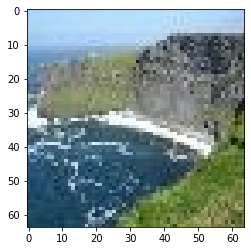

Source image to be changed:


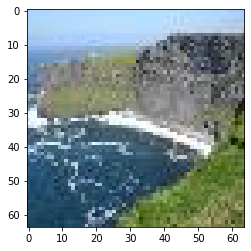

Loss :  0.09403224
Predict of changing image:  7
Logits of changing image:  [9.6346208e-05 9.9026058e-03 4.4682447e-04 1.3636712e-04 2.8567449e-05
 6.0785888e-04 5.3602958e-04 9.3791890e-01 1.0883774e-04 1.9534898e-04
 6.4773723e-03 5.6636694e-04 3.0318081e-06 2.8270653e-05 3.2885876e-02
 3.1439529e-03 3.1630210e-05 7.5169047e-04 6.1061988e-03 2.7946564e-05]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


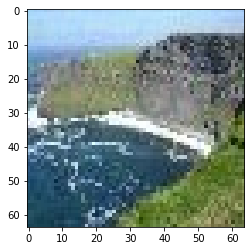

Source image to be changed:


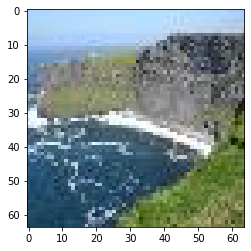

Loss :  0.082555145
Predict of changing image:  7
Logits of changing image:  [2.10696977e-04 1.21277645e-02 1.48104213e-04 1.08750828e-04
 6.08877854e-05 2.87057570e-04 3.78093362e-04 8.27722609e-01
 2.38249358e-02 2.31785030e-04 7.99243152e-03 1.71868640e-04
 1.27743424e-05 2.50596895e-06 1.13503538e-01 2.49777571e-03
 2.34165127e-05 4.08587791e-03 6.39373530e-03 2.15383145e-04]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


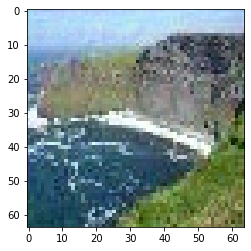

Source image to be changed:


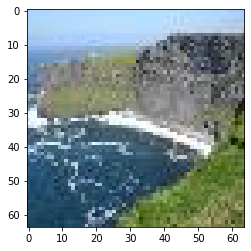

Loss :  0.08138509
Predict of changing image:  7
Logits of changing image:  [2.09738064e-04 1.00065488e-02 1.00532321e-04 9.50245449e-05
 5.87018658e-05 2.44776864e-04 3.75289033e-04 8.14444661e-01
 2.61214543e-02 1.87613216e-04 8.42957757e-03 1.50947380e-04
 1.28903175e-05 1.99251872e-06 1.25696078e-01 2.37220176e-03
 2.09978698e-05 5.48058748e-03 5.75736584e-03 2.33013270e-04]
Logits of attacked image:  [1.0393511e-08 4.9053398e-07 4.4354000e-08 4.0967805e-08 6.8353209e-08
 7.1657658e-10 1.0681646e-09 4.8375520e-10 9.9995017e-01 2.1628838e-07
 4.6135419e-06 3.0615992e-09 2.3826519e-06 7.9418267e-15 5.1893768e-08
 1.8341718e-09 1.3244557e-08 4.0880564e-05 9.7471013e-07 2.4688459e-08]
Changed image:


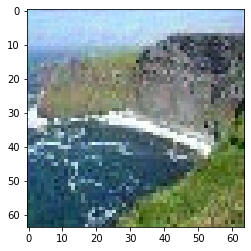

Source image to be changed:


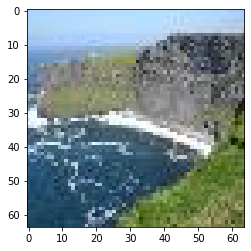

In [72]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign, with_jpeg=True)

Attacked image: 
Logits:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Predicted:  16
Real:  16


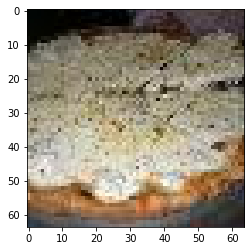

Changing image: 
Logits:  [8.2167814e-04 2.3756216e-01 1.9502308e-03 8.8314014e-03 5.1506169e-02
 2.1632865e-02 2.2801086e-03 3.3965090e-04 6.8882732e-03 7.4362708e-03
 9.1943378e-03 1.0225212e-02 7.4067358e-03 2.2338128e-03 1.2629356e-05
 3.4698818e-03 3.1793494e-05 1.7180233e-04 4.4277295e-01 1.8523198e-01]
Predicted:  18
Real:  18


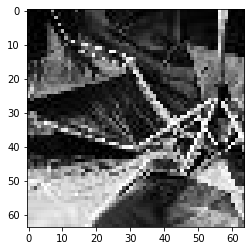

In [73]:
attacked_img, changed_img = choose_images(model, X_val=X_val, y_val=y_val)

Loss :  0.06019791
Predict of changing image:  1
Logits of changing image:  [2.2926722e-03 4.0034002e-01 7.2302815e-04 5.6417722e-02 1.3263750e-01
 3.5430670e-02 2.0039750e-03 6.0316798e-04 1.4882964e-02 6.3375374e-03
 9.3440423e-03 9.9737691e-03 1.7584078e-02 1.3502546e-02 1.8722232e-05
 2.0574197e-02 3.7571840e-04 2.5690647e-04 2.7659746e-02 2.4904101e-01]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


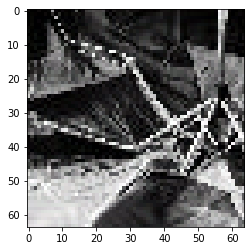

Source image to be changed:


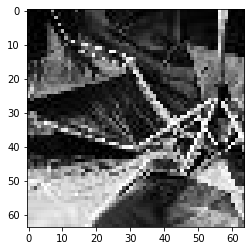

Loss :  0.00021709295
Predict of changing image:  16
Logits of changing image:  [7.0760734e-03 1.7560144e-03 1.1780461e-02 1.4821904e-04 3.8928222e-03
 2.2254197e-03 7.0232237e-03 1.3541892e-03 2.6489864e-04 3.3271189e-03
 2.4268069e-04 2.0869382e-02 7.7114410e-06 7.4613285e-03 2.1353071e-04
 2.0214675e-03 9.2066246e-01 2.2356015e-05 8.9182192e-03 7.3231419e-04]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


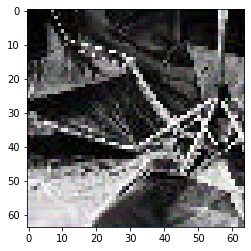

Source image to be changed:


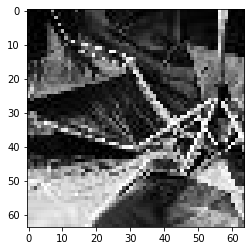

Loss :  1.991606e-05
Predict of changing image:  16
Logits of changing image:  [2.78388645e-04 2.18141322e-05 1.11539164e-04 5.99663508e-07
 6.22289081e-05 1.53701749e-05 1.31716384e-04 7.82615389e-05
 3.69323811e-06 9.08873626e-05 8.37076823e-06 2.35223531e-04
 6.20500273e-08 3.70935537e-04 5.35902882e-06 2.06381610e-05
 9.97851372e-01 1.57865060e-07 6.52653223e-04 6.07728289e-05]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


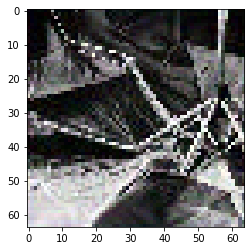

Source image to be changed:


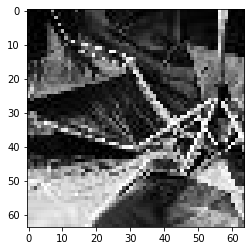

Loss :  1.6007862e-05
Predict of changing image:  16
Logits of changing image:  [7.0338865e-04 4.0920739e-05 3.2034732e-04 1.4574279e-06 7.8550998e-05
 2.1505202e-05 4.3066312e-04 1.5229032e-04 8.4707417e-06 1.9009529e-04
 2.5961435e-05 4.7250983e-04 2.6867124e-07 4.0747292e-04 1.3183984e-05
 3.4488108e-05 9.9558723e-01 5.4402375e-07 1.3698027e-03 1.4074858e-04]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


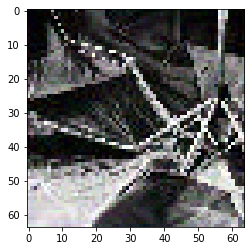

Source image to be changed:


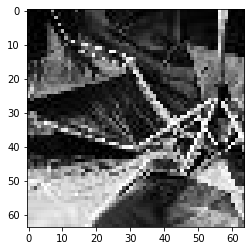

In [74]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign)

Loss :  0.059285175
Predict of changing image:  1
Logits of changing image:  [8.04574927e-04 3.30404967e-01 1.20555784e-03 1.39196282e-02
 1.02000356e-01 3.39113697e-02 1.57098286e-03 4.33208741e-04
 9.00030788e-03 5.91976242e-03 1.01483036e-02 9.69614461e-03
 9.87605657e-03 5.18092047e-03 1.59969150e-05 8.31208471e-03
 4.86314457e-05 1.97763511e-04 2.55047143e-01 2.02306286e-01]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


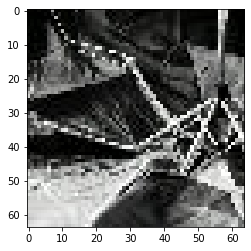

Source image to be changed:


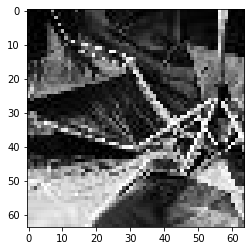

Loss :  0.057886284
Predict of changing image:  18
Logits of changing image:  [5.0388467e-03 1.1773900e-01 1.3430028e-02 4.6658614e-03 1.7397626e-01
 5.2622575e-02 9.6556023e-03 2.0443932e-03 1.6102573e-02 1.5837867e-02
 1.0989057e-02 4.4114798e-02 2.3629272e-03 2.5600137e-02 2.4644018e-04
 2.0794850e-02 4.1589360e-03 5.8196008e-04 3.8341808e-01 9.6619748e-02]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


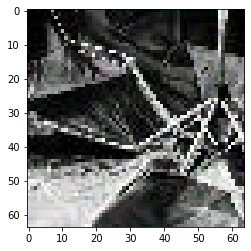

Source image to be changed:


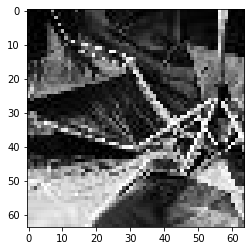

Loss :  0.056959897
Predict of changing image:  18
Logits of changing image:  [0.00889581 0.08119754 0.01337571 0.0022216  0.12041382 0.03168804
 0.01138224 0.00312728 0.01453595 0.01740271 0.01236225 0.04792264
 0.00127375 0.03537316 0.00046479 0.02353293 0.02248303 0.00053269
 0.42538366 0.12643053]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


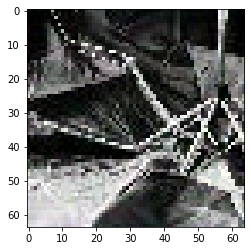

Source image to be changed:


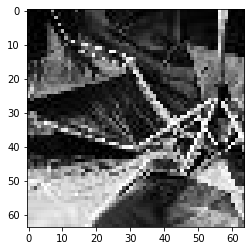

Loss :  0.057297654
Predict of changing image:  18
Logits of changing image:  [0.00824279 0.07535329 0.01092585 0.00185714 0.1319785  0.03004752
 0.00945973 0.00302481 0.01526388 0.0168166  0.01629884 0.03877692
 0.00123092 0.03610518 0.000504   0.02532037 0.02309761 0.00065091
 0.43496776 0.12007745]
Logits of attacked image:  [1.0829176e-03 3.0672178e-04 1.9986728e-06 3.5807826e-03 4.0817272e-06
 9.3119976e-04 3.0231845e-07 5.9074350e-03 1.7083135e-04 4.0647810e-05
 1.2141219e-03 6.8217942e-06 3.9035303e-03 1.3080199e-07 3.2452989e-04
 3.4583735e-04 9.7965211e-01 4.9721706e-04 8.2018680e-04 1.2085418e-03]
Changed image:


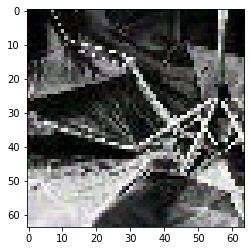

Source image to be changed:


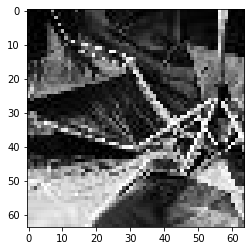

In [75]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign, with_jpeg=True)

В данном случае атака исчезла после прогона картинки через jpeg

Attacked image: 
Logits:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Predicted:  15
Real:  15


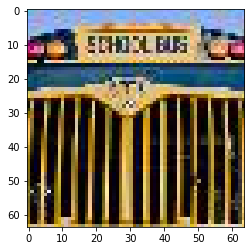

Changing image: 
Logits:  [9.5798350e-05 4.2054351e-04 2.4333576e-04 2.4293173e-02 3.3365680e-08
 4.8767433e-06 2.2055372e-03 9.3197605e-06 1.2138827e-04 4.2585513e-04
 2.5148661e-04 1.4135609e-03 9.6823770e-01 5.4019426e-07 5.3065642e-06
 4.9324037e-04 7.9166794e-06 5.6436816e-06 4.2582428e-04 1.3388994e-03]
Predicted:  12
Real:  12


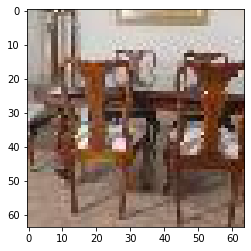

In [76]:
attacked_img, changed_img = choose_images(model, X_val=X_val, y_val=y_val)

Loss :  0.07157067
Predict of changing image:  12
Logits of changing image:  [1.85766176e-03 7.73810595e-03 3.19864415e-03 3.04570228e-01
 1.94590598e-06 8.01924180e-05 3.96057107e-02 2.09124002e-04
 9.52152361e-04 9.48567037e-03 2.84716673e-03 2.78204642e-02
 5.82264006e-01 1.27505355e-05 3.98649427e-05 1.51334784e-03
 1.28666463e-04 3.89198649e-05 4.98385914e-03 1.26515254e-02]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


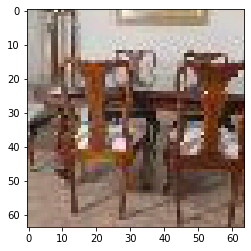

Source image to be changed:


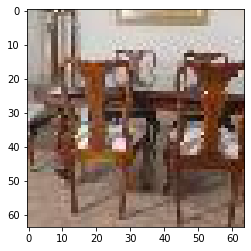

Loss :  5.9932086e-07
Predict of changing image:  15
Logits of changing image:  [6.0811374e-08 4.7710393e-05 3.2574209e-04 4.2940239e-05 2.4723351e-05
 7.8205608e-07 2.4956142e-05 6.4029869e-06 3.8202035e-07 5.8060000e-06
 9.3533781e-06 2.1022013e-05 1.4338470e-03 9.5154397e-04 7.0022438e-08
 9.9698812e-01 1.1412816e-07 5.4118199e-09 9.8178665e-05 1.8213053e-05]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


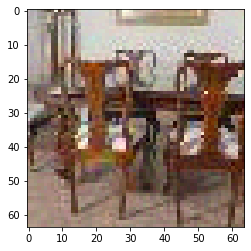

Source image to be changed:


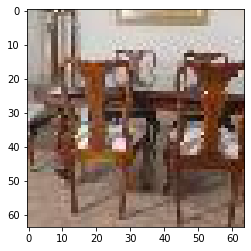

Loss :  4.123046e-11
Predict of changing image:  15
Logits of changing image:  [5.3910418e-12 1.6860841e-07 8.5539286e-06 1.4409598e-08 6.1374621e-09
 1.9388587e-10 3.2235397e-07 1.3330743e-08 3.1515519e-11 1.3372329e-08
 3.4398127e-08 1.2235350e-07 3.4337384e-07 5.5809774e-06 9.8410134e-12
 9.9998379e-01 1.2060510e-09 1.7962018e-13 1.1161422e-06 5.3677183e-09]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


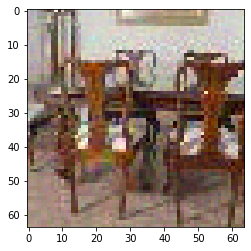

Source image to be changed:


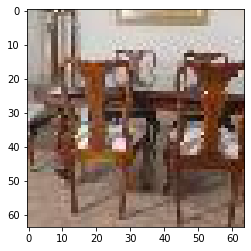

Loss :  5.7530414e-11
Predict of changing image:  15
Logits of changing image:  [9.1374443e-12 6.5838151e-08 6.0225415e-07 1.3098676e-07 1.0609198e-09
 1.7600738e-10 5.9698380e-08 8.7155980e-09 5.8557020e-11 1.1261862e-08
 4.7766310e-08 5.9510228e-08 1.9362401e-06 4.9572122e-07 6.6490333e-12
 9.9999595e-01 1.2800530e-09 1.1825668e-13 7.1531321e-07 1.6048702e-08]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


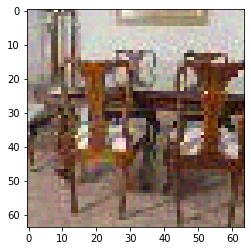

Source image to be changed:


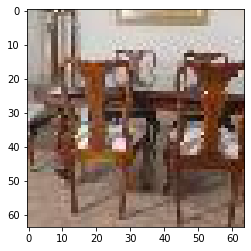

In [77]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign)

Loss :  0.093771644
Predict of changing image:  12
Logits of changing image:  [2.1952456e-04 8.2729431e-04 3.1297078e-04 5.0050624e-02 1.0471691e-07
 1.9162680e-05 3.6140711e-03 2.2709872e-05 2.1850735e-04 9.5950480e-04
 6.4930675e-04 2.7756444e-03 9.3503976e-01 1.2589114e-06 1.8309465e-05
 6.7545689e-04 2.2465872e-05 1.8548855e-05 1.1660658e-03 3.3887282e-03]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


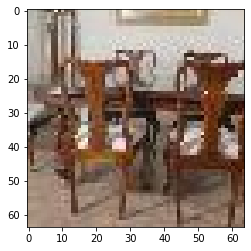

Source image to be changed:


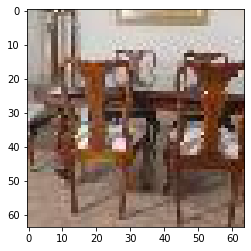

Loss :  0.08243879
Predict of changing image:  12
Logits of changing image:  [5.9375197e-05 1.6101302e-03 1.5769018e-03 2.2919238e-02 5.5150954e-06
 5.6541616e-05 2.2334775e-03 1.2822327e-04 1.0898776e-04 7.5702544e-04
 8.4910350e-04 2.8440484e-03 8.8743258e-01 6.3688080e-05 1.6428095e-05
 7.2249517e-02 1.9498171e-05 1.0379149e-05 2.6800989e-03 4.3793097e-03]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


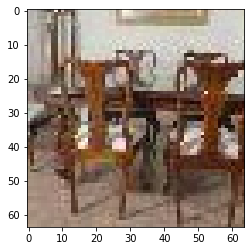

Source image to be changed:


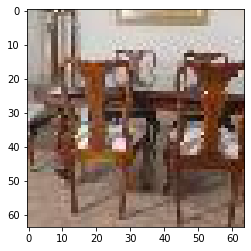

Loss :  0.023129718
Predict of changing image:  15
Logits of changing image:  [1.1566845e-05 6.5960857e-04 2.8153325e-03 5.3947498e-03 7.1202367e-06
 1.6758357e-05 1.3252073e-03 8.3085819e-05 3.3343775e-05 2.9638756e-04
 4.4093671e-04 1.3417457e-03 4.7298142e-01 9.4517774e-05 3.1955865e-06
 5.1126271e-01 5.2348096e-06 1.4214124e-06 1.3809998e-03 1.8445976e-03]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


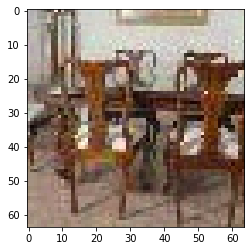

Source image to be changed:


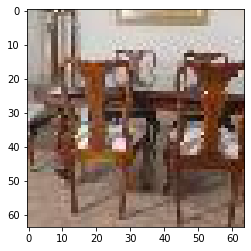

Loss :  0.012376593
Predict of changing image:  15
Logits of changing image:  [4.5916195e-06 3.7527390e-04 7.9467008e-04 4.4019879e-03 4.2856113e-06
 9.8518913e-06 4.9854635e-04 3.9950992e-05 1.8112678e-05 1.6683836e-04
 3.2860396e-04 6.2070077e-04 3.4682995e-01 4.5249861e-05 1.6007699e-06
 6.4329714e-01 3.1230531e-06 5.5313848e-07 1.1559139e-03 1.4030915e-03]
Logits of attacked image:  [1.20036215e-16 3.99024092e-10 2.28427581e-07 1.22850063e-11
 5.90203575e-09 1.03768170e-17 1.12911576e-10 2.61858684e-21
 5.71661477e-15 3.48871431e-12 2.40625013e-06 2.06921069e-13
 7.26794099e-07 7.55504058e-13 1.41517492e-18 9.99972343e-01
 4.48611376e-23 5.78341472e-19 4.66170711e-08 2.42152109e-05]
Changed image:


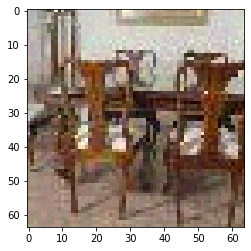

Source image to be changed:


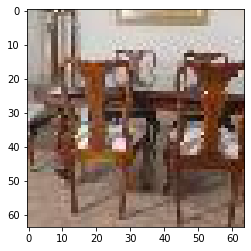

In [78]:
attack(model, attacked_img, changed_img, eps=0.005, fn=tf.sign, with_jpeg=True)

Атака произошла в обоих случаях